# EDA for Data Incubator project proposal, fall 2020

*Draft 1: How does performance relate to compensation in publicly funded universities?

*Draft 2: How to best model enrollement at public universities?

<hr>

## Purpose of this Jupyter notebook is to work on time series models 

### Here's [my project dashboard](http://barb-data-inc.herokuapp.com/) showing last updated version of dashboard/report.

Refs here:


In [ ]:
# --------------------------------
# IMPORT MODULES & LOAD DATA
# --------------------------------
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Import saved csv to dataframe:
path2file="./data/interim/analyzeMe_n175.csv"
df = pd.read_csv(path2file, na_values=np.nan,#parse_dates=['year'], 
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category',
                         'enrollement_rate': 'float64', 'female_pct': 'float64', 'married_pct': 'float64'})

# Set 'year' as datetime 
df['year'] = df['year'].apply(pd.to_datetime, format='%Y')

# Keep these columns (subset from CSV) as potential features for model:
keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
        'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
       'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
        'completers_150pct','completion_rate_150pct','female_pct','married_pct',
      'year','unitid','inst_name','state_name']

dropcols = [c for c in df.columns if c not in keepcols]

df.drop(dropcols,axis=1,inplace=True)


## Estimate a fixed effect regression
#### On a panel (entities = universities) of the admission_rate 

In [1]:
import pandas as pd
import numpy as np

pathDir = '/Users/bhs//PYTHON-STUFF/DataIncubator/does_good_payoff/data/interim/'
filename = 'analyzeMe_n175.csv' 

# 7/31/20
# Note: I need to get better at detecting strings in the data columns ... took longer than it should have 
#      to get the model working because of lurking "Suppressed data" values lurking unexpectedly... 
#      To generate the next file above, I manually went in and Find-Replaced those values w blanks


In [2]:
def augmented_dicky_fuller_statistics(time_series):
    from statsmodels.tsa.stattools import adfuller
    """
    Run the augmented Dicky-Fuller test on a time series to determine if it's stationary
    Arguments:
        time_series:  series. Time series to be tested. 
    Output: 
        Test statistics for the augmented Dicky Fuller test in the console
    """
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
    return result


## EVALUATE SUMMARY STATS OF VARIABLES

After running the next couple of cells, I should be able to evaluate:

(1) Are the features are heterscedastic? 
(i.e. do they have similar variances)
If not, hopefully log transform will fix that

(2) Is a time series of the predictor stationary? (prereq for VAR forecasting model)

See file: ../data/processed/

In [23]:
df = pd.read_csv(pathDir+filename, na_values=np.nan,#parse_dates=['year'], 
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category',
                         'enrollement_rate': 'float64', 'female_pct': 'float64', 'married_pct': 'float64'})

# Drop years earlier than 2001 (availability of key measures)
df = df[df.year>=2001];

# Set 'year' as datetime 
df['year'] = df['year'].apply(pd.to_datetime, format='%Y')

# Keep these columns (subset from CSV) as potential features for model:
keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
        'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
       'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
        'completers_150pct','completion_rate_150pct','female_pct','married_pct',
      'year','unitid','inst_name','state_name']

dropcols = [c for c in df.columns if c not in keepcols]

df.drop(dropcols,axis=1,inplace=True)

# Dropna - TODO: how many na/s
df.dropna(inplace=True)


In [4]:
#  *** GOAL : create an awesome summary of population stats ***
# -----------------------------
# STEP 1 DEFINE A MULTILEVEL INDEX
# https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html

keepcols = keepcols[:-4]
index=[]
for k in keepcols:
    index.append((k, 'Raw'))
    index.append((k, 'Log'))
    index.append((k, 'Log-Diff'))
    index.append((k, 'Diff'))

# -----------------------------
# STEP 2: CREATE ALL THE SERIES I NEED TO SUMMARIZE:
mean, med, varz, adf_stat, adf_pval = [], [], [], [], []
for t in index:
    print(t)
    if t[1]=='Raw':
        ser=df[t[0]]
        ts=df[[t[0],'year']].groupby('year').agg(np.mean)
    elif t[1]=='Log':
        ser=np.log(df[t[0]])
        df['tmp']=np.log(df[t[0]])
        ts=df[['tmp','year']].groupby('year').agg(np.mean)
    elif t[1]=='Log-Diff':
        ser=np.log(df[t[0]]).diff(1)
        df['tmp']=np.log(df[t[0]]).diff(1)
        ts=df[['tmp','year']].groupby('year').agg(np.mean)
    elif t[1]=='Diff':
        ser=df[t[0]].diff(1)
        df['tmp']=df[t[0]].diff(1)
        ts=df[['tmp','year']].groupby('year').agg(np.mean)
    # mean, med, and varz are collapsed across all years, unitids for that feature:
    mean.append(np.mean(ser))
    med.append(np.median(ser))
    varz.append(np.var(ser))   
    # adf test looks at stationarity of feature over time, store results:
    res=augmented_dicky_fuller_statistics(ts)
    adf_stat.append(res[0])
    adf_pval.append(res[1])
    df.drop('tmp',axis=1,inplace=True,errors='ignore')

# -----------------------------
# STEP 3: PUT IT ALL TOGETHER, 
index = pd.MultiIndex.from_tuples(index)

tmp1 = pd.DataFrame(mean, index=index, columns=['mean']).reindex(index)
tmp2 = pd.DataFrame(med, index=index, columns=['median']).reindex(index)
tmp3 = pd.DataFrame(varz, index=index, columns=['variance']).reindex(index)
tmp4 = pd.DataFrame(adf_stat, index=index, columns=['ADF_stat']).reindex(index)
tmp5 = pd.DataFrame(adf_pval, index=index, columns=['ADF_pval']).reindex(index)

summary_transformed = pd.concat([tmp1, tmp2, tmp3, tmp4, tmp5], axis=1)

summary_transformed.to_csv(pathDir+'Summarize_Feature_distributions.csv')
print(f"Saved file: {pathDir+'Summarize_Feature_distributions.csv'}")

('admission_rate', 'Raw')
ADF Statistic: -1.555745
p-value: 0.505777
('admission_rate', 'Log')
ADF Statistic: -1.426692
p-value: 0.569415
('admission_rate', 'Log-Diff')
ADF Statistic: -0.831105
p-value: 0.809814
('admission_rate', 'Diff')
ADF Statistic: -2.037898
p-value: 0.270207
('enrollement_rate', 'Raw')
ADF Statistic: -7.656645
p-value: 0.000000
('enrollement_rate', 'Log')
ADF Statistic: -3.314700
p-value: 0.014234
('enrollement_rate', 'Log-Diff')
ADF Statistic: -36.479736
p-value: 0.000000
('enrollement_rate', 'Diff')
ADF Statistic: -1.152748
p-value: 0.693585
('number_applied', 'Raw')
ADF Statistic: -1.119933
p-value: 0.707058
('number_applied', 'Log')
ADF Statistic: -2.738359
p-value: 0.067632
('number_applied', 'Log-Diff')
ADF Statistic: -49.419087
p-value: 0.000000
('number_applied', 'Diff')
ADF Statistic: -1.474230
p-value: 0.546219
('number_admitted', 'Raw')
ADF Statistic: -0.260400
p-value: 0.930929
('number_admitted', 'Log')
ADF Statistic: -0.543636
p-value: 0.883216
('nu

/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


ADF Statistic: 0.400892
p-value: 0.981528
('number_enrolled_total', 'Log')
ADF Statistic: -1.469277
p-value: 0.548651
('number_enrolled_total', 'Log-Diff')
ADF Statistic: -2.101860
p-value: 0.243767
('number_enrolled_total', 'Diff')
ADF Statistic: -3.034104
p-value: 0.031830
('rev_tuition_fees_gross', 'Raw')
ADF Statistic: 3.043218
p-value: 1.000000
('rev_tuition_fees_gross', 'Log')
ADF Statistic: -2.491035
p-value: 0.117671
('rev_tuition_fees_gross', 'Log-Diff')
ADF Statistic: 0.854675
p-value: 0.992469
('rev_tuition_fees_gross', 'Diff')
ADF Statistic: -3.102969
p-value: 0.026334
('rev_tuition_fees_net', 'Raw')
ADF Statistic: 2.010375
p-value: 0.998686
('rev_tuition_fees_net', 'Log')
ADF Statistic: -2.781894
p-value: 0.060907
('rev_tuition_fees_net', 'Log-Diff')
ADF Statistic: -31.670009
p-value: 0.000000
('rev_tuition_fees_net', 'Diff')
ADF Statistic: -1.123494
p-value: 0.705612
('rev_total_current', 'Raw')
ADF Statistic: 22.212395
p-value: 1.000000
('rev_total_current', 'Log')
ADF S

/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in log


ADF Statistic: -0.497093
p-value: 0.892583
('exp_total_current', 'Log-Diff')
ADF Statistic: -4.622442
p-value: 0.000117
('exp_total_current', 'Diff')
ADF Statistic: -3.872794
p-value: 0.002244
('exp_instruc_total', 'Raw')
ADF Statistic: -0.008750
p-value: 0.957802
('exp_instruc_total', 'Log')
ADF Statistic: -1.889883
p-value: 0.336835
('exp_instruc_total', 'Log-Diff')
ADF Statistic: -1.606175
p-value: 0.480491
('exp_instruc_total', 'Diff')
ADF Statistic: -1.853676
p-value: 0.354157
('exp_acad_supp_total', 'Raw')
ADF Statistic: 2.317238
p-value: 0.998966
('exp_acad_supp_total', 'Log')
ADF Statistic: -43.417694
p-value: 0.000000
('exp_acad_supp_total', 'Log-Diff')
ADF Statistic: -2.192561
p-value: 0.208956
('exp_acad_supp_total', 'Diff')
ADF Statistic: -1.923926
p-value: 0.320891
('exp_student_serv_total', 'Raw')
ADF Statistic: 4.117425
p-value: 1.000000
('exp_student_serv_total', 'Log')
ADF Statistic: -1.813209
p-value: 0.373924
('exp_student_serv_total', 'Log-Diff')
ADF Statistic: -1.2

In [ ]:
# # CHARACTERIZE THE FEATURES & PRINT RESULTS TO CONSOLE:

# whichVar ='enrollement_rate' 

# minYr=df.groupby('year')[whichVar].agg(np.mean).index[0].year
# maxYr=df.groupby('year')[whichVar].agg(np.mean).index[-1].year

# # Raw feature values
# print(f"\n---{whichVar.upper()}: Summary stats (all years)---")
# print(df[[whichVar]].agg([np.mean, np.median, np.var, 'count']))
# print(f"\nTest for stationarity of time series ***{minYr}-{maxYr}***" )
# print(augmented_dicky_fuller_statistics(df.groupby('year')[whichVar].agg(np.mean)))

# # Log transformed values
# df[whichVar+'_log'] = np.log(df[whichVar])
# print(f"\n---LOG of {whichVar.upper()}: Summary stats (all years)---")
# print(df[[whichVar+'_log']].agg([np.mean, np.median, np.var, 'count']))
# print(f"\nTest for stationarity of time series ***{minYr}-{maxYr}***" )
# print(augmented_dicky_fuller_statistics(df.groupby('year')[whichVar+'_log'].agg(np.mean)))

# # Differenced Log transformed values
# df[whichVar+'_log_diff'] = df[whichVar+'_log'].diff(1)
# print(f"\n--- DIFFERENCED, LOG of {whichVar.upper()}: Summary stats (all years)---")
# print(df[[whichVar+'_log_diff']].agg([np.mean, np.median, np.var, 'count']))
# print(f"\nTest for stationarity of time series ***{minYr}-{maxYr}***" )
# print(augmented_dicky_fuller_statistics(df.groupby('year')[whichVar+'_log_diff'].agg(np.mean)))

# # Differenced raw values
# df[whichVar+'_diff'] = df[whichVar].diff(1)
# print(f"\n---DIFFERENCED {whichVar.upper()}: Summary stats (all years)---")
# print(df[[whichVar+'_diff']].agg([np.mean, np.median, np.var, 'count']))
# print(f"\nTest for stationarity of time series ***{minYr}-{maxYr}***" )
# print(augmented_dicky_fuller_statistics(df.groupby('year')[whichVar+'_diff'].agg(np.mean)))


## Decide how each feature should be transformed & make a new dataframe

Ok, I decided. **Transforming the features by Log & Diff is the way to go.**
- I looked at the mean, variance, and stationarity of each of the tranformations for each of the features. 
- The features are homeoskedastic (similar variance = 0) with this tranformation.
- Also, the time series are stationary under this transformation. 
- Perhaps that will lead to better model results.


## Setup data for models: Raw and Transformed 

APPROACH:
- Run models on Raw and Transformed features
- For each: Train on data from 2001-2016, use 11 features to predict each school's "number_enrolled_total" 
- Evaluate models performance on predicting 2017 "number_enrolled_total"

In [24]:
# "INITIALLY" STARTED OFF WITH 20 FEATURES:
keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
        'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
       'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
        'completers_150pct','completion_rate_150pct','female_pct','married_pct']


df_trans = df.copy()
df_log = df.copy()
df_diff = df.copy()

#Take LOG & then DIFFERENCE the elements
for k in keepcols:
    df_trans[k] = np.log(df[k]).diff(1)  

#Take LOG
for k in keepcols:
    df_log[k] = np.log(df[k]) 
 
#DIFFERENCE the elements
for k in keepcols:
    df_diff[k]=df[k].diff(1)

# Setup Multilevel index for Panel models:
df = df.set_index(['unitid','year'])
df_trans = df_trans.set_index(['unitid','year'])
df_log = df_log.set_index(['unitid','year'])
df_diff = df_diff.set_index(['unitid','year'])



/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log


In [6]:
# IMPORT ALL THE LIBRARIES NEEDED:

from linearmodels.panel import PooledOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare
import statsmodels.api as sm


## 1. Basic regression on panel data
PooledOLS is just plain Oridinary Least Squares that understands panel data structures.
It can be useful as a base model:
    

In [52]:
# TOGGLE BTWN WHICH FEATURES TO USE: 
# -RAW  -LOG_DIFF  -LOG  -DIFF

# DF, TRANS_TYPE = df, 'RAW'

DF, TRANS_TYPE = df_trans, 'LOG_DIFF'

# DF, TRANS_TYPE = df_log,  'LOG'

# DF, TRANS_TYPE = df_diff, 'DIFF'

# What's being predicted:
whichVar = 'number_enrolled_total'
dependent = DF[whichVar]

# Settle on regressors:
modelcols = [c for c in keepcols if c not in [whichVar,'admission_rate','enrollement_rate','year','unitid','inst_name','state_name']]

# Add em to statsmodel:
exog = sm.add_constant(DF[modelcols])

mod = PooledOLS(dependent, exog)
pooled_res = mod.fit()
print(pooled_res)

                            PooledOLS Estimation Summary                           
Dep. Variable:     number_enrolled_total   R-squared:                        0.6936
Estimator:                     PooledOLS   R-squared (Between):              0.9853
No. Observations:                   2510   R-squared (Within):               0.6628
Date:                   Sun, Aug 02 2020   R-squared (Overall):              0.6936
Time:                           22:48:25   Log-likelihood                    1742.1
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      331.86
Entities:                            173   P-value                           0.0000
Avg Obs:                          14.509   Distribution:                 F(17,2492)
Min Obs:                          0.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

## 2. Estimating parameters with uncorrelated effects

This model adds an error componend to the standard OLS model.

The Random effects model is almost identical to the pooled OLD model except that it accounts for the structure of the model; subtracts the time average from the within-entity values.

**y = Xb + c + e**
(in Random effects, the "c" are uncorrelated with regressors)


In [53]:
mod = RandomEffects(dependent, exog)
re_res = mod.fit()
print(re_res)


                          RandomEffects Estimation Summary                         
Dep. Variable:     number_enrolled_total   R-squared:                        0.6936
Estimator:                 RandomEffects   R-squared (Between):              0.9853
No. Observations:                   2510   R-squared (Within):               0.6628
Date:                   Sun, Aug 02 2020   R-squared (Overall):              0.6936
Time:                           22:48:30   Log-likelihood                    1742.1
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      331.86
Entities:                            173   P-value                           0.0000
Avg Obs:                          14.509   Distribution:                 F(17,2492)
Min Obs:                          0.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

In [9]:
# I THINK THESE NUMBERS WOULD BE PRETTY DIFFERENT IF I HADN"T TRANFORMED THE FEATURES

# The quasi-differencing in the random effects estimator depends on a quantity that depends on the #  relative variance of the ideosyncratic shock and the common shock. 
 #This can be accessed using the variance_decomposition:
print(re_res.variance_decomposition)

# Cofficient THETA determines how much demeaning takes place
# when value is 1, the RE model reduces to the pooled model, no variance in the effeicts
# when panels are unbalanced, can vary across entities
print(re_res.theta)

Effects                   81304.606136
Residual                  99989.162896
Percent due to Effects        0.448469
Name: Variance Decomposition, dtype: float64
           theta
unitid          
104151  0.732836
104179  0.732836
105330  0.732836
110422  0.732836
110510  0.732836
110529  0.732836
110538  0.732836
110556  0.732836
110565  0.732836
110583  0.732836
110592  0.732836
110608  0.732836
110617  0.732836
110635  0.732836
110644  0.732836
110653  0.732836
110662  0.732836
110671  0.732836
110680  0.732836
110705  0.732836
110714  0.732836
117946  0.715834
122409  0.732836
122436  0.257349
122597  0.732836
122755  0.732836
122931  0.732836
123572  0.732836
123961  0.732836
243744  0.257349
...          ...
228529  0.732836
228723  0.732836
228769  0.732836
228778  0.732836
228875  0.634975
229027  0.732836
229115  0.732836
231624  0.732836
231712  0.724728
232186  0.732836
232423  0.732836
232557  0.634975
232937  0.724728
232982  0.732836
233277  0.732836
233921  0.732836
23403

# Handling correlated effects with PanelOLS

When effects are correlated with the regressors, the RE and BE estimators are not consistent. 
Hence, use Fixed Effects model (PanelOLS).


## 3a. FIXED EFFECTS: Entity only

Setting entity_effects=True is equivalent including dummies for each entity. Time-invariant variables cannot be included when using entity effects since, once de-meaned, these will be zero. 

In [54]:
# FIXED EFFECTS model: ENTITY only

mod = PanelOLS(dependent, exog, entity_effects=True)
fe_ent_res = mod.fit(cov_type='unadjusted')
print(fe_ent_res)

                            PanelOLS Estimation Summary                            
Dep. Variable:     number_enrolled_total   R-squared:                        0.6630
Estimator:                      PanelOLS   R-squared (Between):              0.9832
No. Observations:                   2510   R-squared (Within):               0.6630
Date:                   Sun, Aug 02 2020   R-squared (Overall):              0.6935
Time:                           22:48:37   Log-likelihood                    1767.2
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      268.83
Entities:                            173   P-value                           0.0000
Avg Obs:                          14.509   Distribution:                 F(17,2323)
Min Obs:                          0.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

## 3b. FIXED EFFECTS: Entity & Time

In [55]:
mod = PanelOLS(dependent, exog, entity_effects=True, time_effects=True)
fe_ent_tm_res = mod.fit(cov_type='unadjusted')
print(fe_ent_tm_res)

                            PanelOLS Estimation Summary                            
Dep. Variable:     number_enrolled_total   R-squared:                        0.6731
Estimator:                      PanelOLS   R-squared (Between):              0.9816
No. Observations:                   2510   R-squared (Within):               0.6245
Date:                   Sun, Aug 02 2020   R-squared (Overall):              0.6595
Time:                           22:49:24   Log-likelihood                    1870.1
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      279.60
Entities:                            173   P-value                           0.0000
Avg Obs:                          14.509   Distribution:                 F(17,2308)
Min Obs:                          0.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

## COMPARE MODELS

In [ ]:
compare({'Pooled': pooled_res, 'RE': re_res, 'Fixed-Ent': fe_ent_res})

In [ ]:
compare({'RE': re_res, 'Fixed-Ent': fe_ent_res, 'Fixed-Ent-Tm': fe_ent_tm_res})

In [ ]:
compare({'Pooled': pooled_res, 'RE': re_res, 'Fixed-Ent-Tm': fe_ent_tm_res})

In [56]:
# Heteroskedasticity Robust Covariance

mod = PooledOLS(dependent, exog)
robust = mod.fit(cov_type='robust')


## 4a. Covariance Options: Cluster by ENTITY

In [57]:

mod = PooledOLS(dependent, exog)
clust_entity = mod.fit(cov_type='clustered', cluster_entity=True)


## 4b. Covariance Options: Cluster by ENTITY & TIME

In [58]:
mod = PooledOLS(dependent, exog)
clust_entity_time = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


In [59]:
from collections import OrderedDict
res = OrderedDict()
res['Robust'] = robust
res['Entity'] = clust_entity
res['Entity-Time'] = clust_entity_time
res['Pooled'] = pooled_res
res['RE'] = re_res
res['FE-ent'] = fe_ent_res
res['FE-ent-tm'] = fe_ent_tm_res

In [73]:
# %%capture cap --no-stderr

# print(compare(res))
# with open('output_model_results_features_'+TRANS_TYPE+'.txt', 'w') as f:
#     f.write(cap.stdout)

clust_entity_time

,const,number_applied,number_admitted,rev_tuition_fees_gross,rev_tuition_fees_net,rev_total_current,rev_fed_approps_grants,rev_state_local_approps_grants,rev_other,exp_total_current,exp_instruc_total,exp_acad_supp_total,exp_student_serv_total,exp_res_pub_serv_total,completers_150pct,completion_rate_150pct,female_pct,married_pct
const,0.000028,-0.000009,-0.000050,-0.000313,0.000149,4.106699e-06,-0.000094,-0.000050,8.861928e-06,-0.000032,0.000143,0.000030,-0.000078,0.000061,0.000550,-0.000654,-0.000115,0.000052
number_applied,-0.000009,0.001576,-0.001068,0.001396,-0.000743,-1.842012e-06,0.000087,0.000017,-2.767436e-05,0.000262,-0.001087,-0.000187,0.000502,-0.000203,-0.001087,0.001298,0.000127,0.000363
number_admitted,-0.000050,-0.001068,0.001396,-0.000490,0.000229,1.049605e-04,0.000118,0.000031,-1.514359e-05,-0.000259,0.000292,0.000235,-0.000086,0.000060,-0.000768,0.000950,0.000058,-0.000213
rev_tuition_fees_gross,-0.000313,0.001396,-0.000490,0.008746,-0.005860,-3.849467e-04,0.001126,0.000693,-1.404130e-04,0.000721,-0.002628,-0.000430,0.001349,-0.000930,-0.007458,0.008370,0.000865,-0.000183
rev_tuition_fees_net,0.000149,-0.000743,0.000229,-0.005860,0.004724,1.318285e-04,-0.000379,-0.000301,6.967498e-05,-0.000348,0.001076,0.000078,-0.000643,0.000457,0.003419,-0.003948,-0.000158,-0.000121
rev_total_current,0.000004,-0.000002,0.000105,-0.000385,0.000132,1.588827e-04,-0.000060,-0.000055,-6.572645e-07,-0.000130,0.000044,0.000076,-0.000020,0.000046,0.000266,-0.000291,-0.000152,0.000013
rev_fed_approps_grants,-0.000094,0.000087,0.000118,0.001126,-0.000379,-6.030173e-05,0.000435,0.000208,-1.736685e-05,0.000054,-0.000633,-0.000142,0.000302,-0.000209,-0.002129,0.002282,0.000307,-0.000288
rev_state_local_approps_grants,-0.000050,0.000017,0.000031,0.000693,-0.000301,-5.524664e-05,0.000208,0.000122,-1.703865e-05,0.000066,-0.000246,-0.000092,0.000120,-0.000106,-0.001090,0.001184,0.000247,-0.000174
rev_other,0.000009,-0.000028,-0.000015,-0.000140,0.000070,-6.572645e-07,-0.000017,-0.000017,7.786711e-06,-0.000032,0.000078,0.000013,-0.000021,0.000012,0.000197,-0.000196,-0.000014,0.000017
exp_total_current,-0.000032,0.000262,-0.000259,0.000721,-0.000348,-1.302910e-04,0.000054,0.000066,-3.172999e-05,0.000164,-0.000279,-0.000101,0.000250,-0.000105,-0.000637,0.000701,0.000065,0.000094


In [ ]:
# Notes from the examples page for linearmodels 4.5
# -------------------------------------------
# Clustering by entity addresses correlation across time
# Clustering by time controls for correlation between entities in a time period.

# In my data:
# "Clustering on entity reduced the t-stats across the board. 
# "This suggests there is important correlation in the residuals per entity
#
# "Clustering by both entity and time is pretty similar => 
#  .... this suggests there may not be cross-sectional dependence in the data


## TIME TO TRY FORECASTING!


In [ ]:
# 11 features for forecasting:
# maybe try first with 3?

DF = df_trans

whichFeatures = ['number_applied', 'number_admitted', 'rev_tuition_fees_net','completers_150pct',
                 'rev_fed_approps_grants', 'rev_state_local_approps_grants', 'rev_other',
               'exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total']



## Time to fit the VAR model!
Left it here on Sunday night, 8/2/20

In [ ]:
# Remember, this is the general flow...

# Convert the dataframe to a numpy array
master_array = np.array(master_df[['Electricity_Price_log_diff','Nat_Gas_Price_MCF_log_diff']])

# Generate a training and test set for building the model (90/10 split)
training_set = master_array[1:int(0.90*master_array.shape[0])]  #Why sample in order???
test_set = master_array[int(0.90*master_array.shape[0]):]

# Fit to a VAR model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(endog=training_set)
model_fit = model.fit()

# Print a summary of the model results
model_fit.summary()


## 8-5-20: Trying out the analyses for demo in app.py  (kernel py37t)
Refs:
https://bashtage.github.io/linearmodels/doc/panel/examples/examples.html
<hr>

In [11]:
# --------------------------------
# IMPORT MODULES
# --------------------------------
import pandas as pd
import numpy as np
from datetime import datetime as dt

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Prune as necessary:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import chart_studio.plotly as py
import plotly
import cufflinks as cf

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Create a variable, options, with a list of dicts w/ keys {'label': , 'value'}
def make_options(df):
    n=df.unitid.nunique()
    state_options=[{'label': 'All '+str(n)+" schools", 'value':''}]
    for state in df.state_name.unique():
        n=df.groupby(['state_name'])['number_applied'].count().loc[state]
        state_options.append({'label': state+" ("+str(n)+" schools)", 'value': state })
    return state_options


In [2]:
# --------------------------------
# Acquire the Data:
# --------------------------------
path2file="/Users/bhs/PYTHON-STUFF/DataIncubator/does_good_payoff/data/interim/analyzeMe_n175.csv"
df = pd.read_csv(path2file, na_values=np.nan,#parse_dates=['year'], 
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category',
                         'enrollement_rate': 'float64', 'female_pct': 'float64', 'married_pct': 'float64'})

# --------------------------------
# Data Prune:
# --------------------------------

# Drop years earlier than 2001 (availability of key measures)
df = df[df.year>=2001];

# Set 'year' as datetime 
df['year'] = df['year'].apply(pd.to_datetime, format='%Y')

# Keep these columns (subset from CSV) as potential features for model:
keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
        'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
       'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
        'completers_150pct','completion_rate_150pct','female_pct','married_pct',
      'year','unitid','inst_name','state_name']

dropcols = [c for c in df.columns if c not in keepcols]
df.drop(dropcols,axis=1,inplace=True)


In [4]:
# SET CRITERIA:
# Identify schools with data in all years, only include those:
nYrs= 17
tmpDf = df.groupby(['unitid'])[['enrollement_rate']].count()
unitids = tmpDf[tmpDf.enrollement_rate==nYrs].index.to_list()
filt = df.apply(lambda row: row['unitid'] in unitids, axis=1)

df = df[filt]
state_options_enrollment = make_options(df)

In [6]:
# --------------------------------
# Identify which data view:
# --------------------------------

# Identify data columns
which_columns = ['admission_rate','enrollement_rate']

# Simulate select-state dropdown menu:
selected=''  # 'Texas'

if len(selected)==0:
    dfTs = df.groupby(['year'])[which_columns].apply(np.mean)
else:
    dfTs = df[df.state_name==selected].groupby(['year'])[which_columns].apply(np.mean)


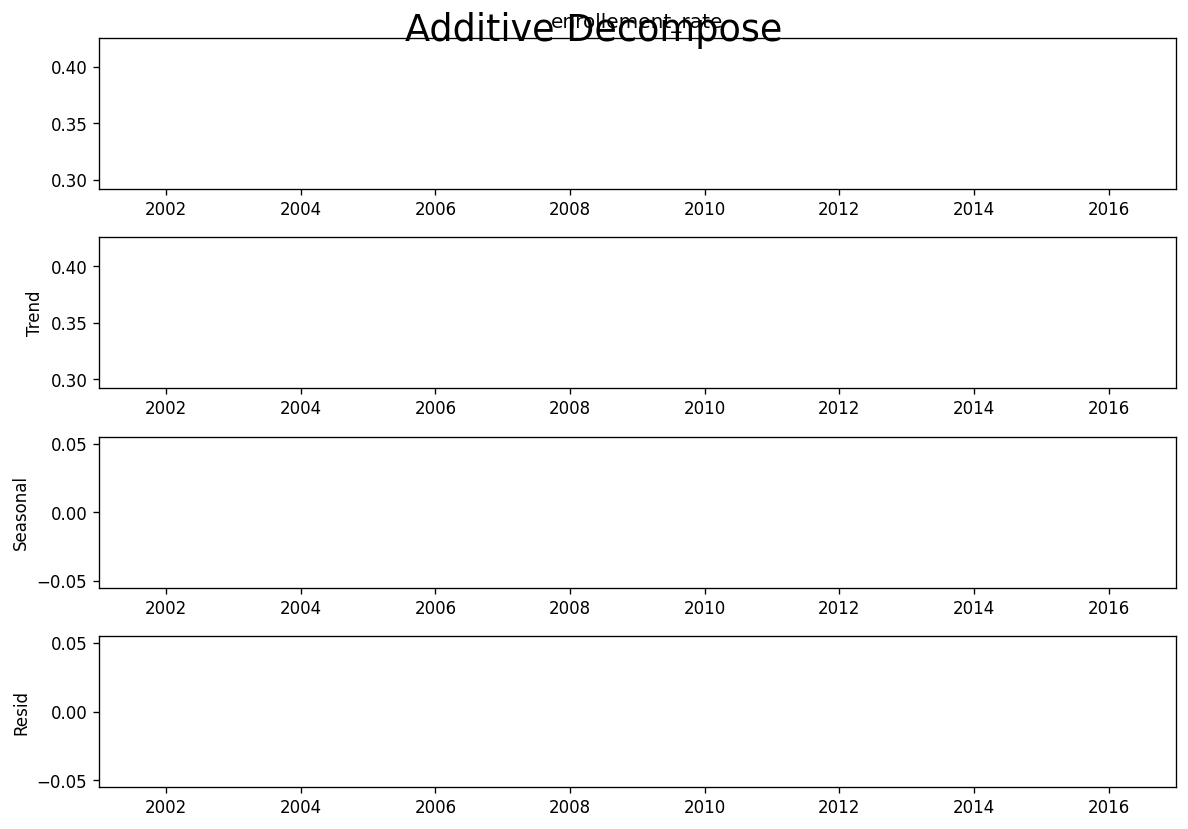

In [14]:
## Decompose our time series into its components:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Multiplicative Decomposition
result_mul = seasonal_decompose(dfTs['enrollement_rate'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(dfTs['enrollement_rate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [15]:
dfTs

,admission_rate,enrollement_rate
year,,
2001-01-01,0.676598,0.415516
2002-01-01,0.655803,0.419503
2003-01-01,0.653038,0.405596
2004-01-01,0.644871,0.394557
2005-01-01,0.642246,0.384695
2006-01-01,0.632621,0.378095
2007-01-01,0.625875,0.363006
2008-01-01,0.606079,0.362672
2009-01-01,0.602123,0.354221


In [9]:
## NOTE: Don't need to Normalize input & target feature(s) this time b/c looking at rates:

# Actually, this first forecast model is done on the rates... so already between 0 and 1. Yay!


In [ ]:
## Step 2- Train/Test split